# Pandas 3:  Shaping data  

The second in a series of notebooks that describe Pandas' powerful data management tools.  This one covers shaping methods:  switching rows and columns, pivoting, and stacking.  We'll see that this is all about the indexes:  the row and column labels.  

Outline:  

* [Examples](#wants)
* [Indexing](#index).  Setting and resetting the index.  Multi-indexes. 
* [Switching rows and columns](#pivot).  Transpose.  Pivot and melt.  
* [Stack and unstack](#stack).  Managing column structure and labels.  Melt.  

More data management topics coming.  

**Note: requires internet access to run.**  

<!-- 
internal links http://sebastianraschka.com/Articles/2014_ipython_internal_links.html
-->

This IPython notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

In [23]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

%matplotlib inline                     

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Today:  2016-04-11


<a id=wants></a>

## Example:  World Economic Outlook 

We spend most of our time on just one of the examples from the previous notebook. The problem in this example is that variables run across rows, rather than down columns.  Our **want** is to flip rows and columns somehow so that we can plot the data against time.  The question is how.

We use a small subset of the IMF's [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28) that contains two variables and three countries.  

In [54]:
url1 = 'http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/'
url2 = 'WEOOct2015all.xls'
url = url1 + url2 
weo = pd.read_csv(url, sep='\t', 
                  usecols=[1,2,3,4,6,40,41,42], 
                  thousands=',', 
                  na_values=['n/a', '--']) 
print('Variable dtypes:\n', weo.dtypes, sep='')

Variable dtypes:
ISO                    object
WEO Subject Code       object
Country                object
Subject Descriptor     object
Units                  object
2011                  float64
2012                  float64
2013                  float64
dtype: object


In [55]:
# create debt and deficits dataframe:  two variables and three countries 
variables = ['GGXWDG_NGDP', 'GGXCNL_NGDP']
countries = ['ARG', 'DEU', 'GRC']
dd = weo[weo['WEO Subject Code'].isin(variables) & weo['ISO'].isin(countries)]

# change column labels to something more intuitive 
dd = dd.rename(columns=
                         {'WEO Subject Code': 'Variable', 
                          'Subject Descriptor': 'Description'})

# rename variables 
dd['Variable'] = dd['Variable'].replace(to_replace=['GGXWDG_NGDP', 'GGXCNL_NGDP'], 
                                        value=['Debt', 'Surplus'])
dd

,ISO,Variable,Country,Description,Units,2011,2012,2013
252,ARG,Surplus,Argentina,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
260,ARG,Debt,Argentina,General government gross debt,Percent of GDP,35.763,37.328,40.217
2716,DEU,Surplus,Germany,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
2724,DEU,Debt,Germany,General government gross debt,Percent of GDP,77.928,79.311,76.978
2804,GRC,Surplus,Greece,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
2812,GRC,Debt,Greece,General government gross debt,Percent of GDP,170.960,156.494,174.951


**Comment.** We might imagine doing several different things with this data:

* Plot a specific variablle (debt or surplus) for a given date. 
* Time series plots for a specific country.
* Time series plots for a specific variable.  

Depending on which we want, we might organize the data differently.  We'll focus on the last two.  

Here's a brute force approach to the problem:  simply transpose the data.  This is where that leads:  

<a id='strings'></a>

In [27]:
# try switching rows and columns
dd.T

,252,260,2716,2724,2804,2812
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.96
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951


**Comments.** The problem here is that the columns include both the numbers (which we want to plot) and some descriptive information (which we don't).  

<a id='missing'></a>

<a id='index'></a>

## Setting and resetting the index

We start by setting and resetting the index.  That may sound like a step backwards -- haven't we done this already? -- but it reminds us of some things that will be handy later.  

Take the dataframe `dd`.  What would we like in the index?  Evenutally we'd like the dates `[2011, 2012, 2013, 2014, 2015]` in the index, but right now the row labels are more naturally the variable or country.  Here are some varriants.  

### Setting the index

In [56]:
dd.set_index(['Country'])

,ISO,Variable,Description,Units,2011,2012,2013
Country,,,,,,,
Argentina,ARG,Surplus,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Argentina,ARG,Debt,General government gross debt,Percent of GDP,35.763,37.328,40.217
Germany,DEU,Surplus,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Germany,DEU,Debt,General government gross debt,Percent of GDP,77.928,79.311,76.978
Greece,GRC,Surplus,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Greece,GRC,Debt,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [57]:
dd.set_index(['Variable'])

,ISO,Country,Description,Units,2011,2012,2013
Variable,,,,,,,
Surplus,ARG,Argentina,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Debt,ARG,Argentina,General government gross debt,Percent of GDP,35.763,37.328,40.217
Surplus,DEU,Germany,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Debt,DEU,Germany,General government gross debt,Percent of GDP,77.928,79.311,76.978
Surplus,GRC,Greece,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Debt,GRC,Greece,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [58]:
# we can do this with two or more if we like 
ddi = dd.set_index(['Variable', 'Country', 'ISO', 'Description', 'Units'])
ddi

,,,,,2011,2012,2013
Variable,Country,ISO,Description,Units,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Debt,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217
Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Debt,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978
Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Debt,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951


**Comment.** This is called a **multi-level** or a **hierarchical** index.  That means the index has more than one component, and the components are ordered -- they have levels.  The outer index has level zero, and we add one as we move in.  

This isn't uncommon.  A typical spreadsheet has two dimensions:  the variable and the observation.  The WEO data is naturally three dimensional:  the variable, the year, and the country.  The problem we're having is fitting this nicely into two dimensions.  A multi-index allows us to manage more than two.  

## Resetting the index

This is the reverse operation to setting the index.  For example:  

In [31]:
ddi.reset_index()

,Variable,Country,ISO,Description,Units,2011,2012,2013
0,Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
1,Debt,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217
2,Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
3,Debt,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978
4,Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
5,Debt,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [32]:
# or we can reset the index level by level
ddi.reset_index(level=1)

,,,,Country,2011,2012,2013
Variable,ISO,Description,Units,,,,
Surplus,ARG,General government net lending/borrowing,Percent of GDP,Argentina,-1.949,-2.359,-1.997
Debt,ARG,General government gross debt,Percent of GDP,Argentina,35.763,37.328,40.217
Surplus,DEU,General government net lending/borrowing,Percent of GDP,Germany,-0.861,0.091,0.133
Debt,DEU,General government gross debt,Percent of GDP,Germany,77.928,79.311,76.978
Surplus,GRC,General government net lending/borrowing,Percent of GDP,Greece,-10.215,-6.406,-2.944
Debt,GRC,General government gross debt,Percent of GDP,Greece,170.960,156.494,174.951


<a id='pivot'></a>

In [33]:
ddi.reset_index(level=[1,3])

,,,Country,Description,2011,2012,2013
Variable,ISO,Units,,,,,
Surplus,ARG,Percent of GDP,Argentina,General government net lending/borrowing,-1.949,-2.359,-1.997
Debt,ARG,Percent of GDP,Argentina,General government gross debt,35.763,37.328,40.217
Surplus,DEU,Percent of GDP,Germany,General government net lending/borrowing,-0.861,0.091,0.133
Debt,DEU,Percent of GDP,Germany,General government gross debt,77.928,79.311,76.978
Surplus,GRC,Percent of GDP,Greece,General government net lending/borrowing,-10.215,-6.406,-2.944
Debt,GRC,Percent of GDP,Greece,General government gross debt,170.960,156.494,174.951


**Comment.** By default, `reset_index` pushes something from the index to a column.  If we want to discard that level of the index altogether, we use the parameter `drop=True`.  

In [60]:
ddi.reset_index(level=[1,3], drop=True)

,,,2011,2012,2013
Variable,ISO,Units,,,
Surplus,ARG,Percent of GDP,-1.949,-2.359,-1.997
Debt,ARG,Percent of GDP,35.763,37.328,40.217
Surplus,DEU,Percent of GDP,-0.861,0.091,0.133
Debt,DEU,Percent of GDP,77.928,79.311,76.978
Surplus,GRC,Percent of GDP,-10.215,-6.406,-2.944
Debt,GRC,Percent of GDP,170.960,156.494,174.951


**Exercise.**  For the dataframe `ddi`:  

* Use the `reset_index` method to move the `Units` level of the index to a column of the dataframe.
* Use the `drop` parameter of `reset_index` to delete `Units` from the dataframe.  
* Show using the previous example that we can refer to the index level with either its numerical level or its name.  

## Switching rows and columns   

If we take the dataframe `ddi`, we see that the everything's been put into the index but the data itself.  Perhaps we can flip the rows and columns and work with that.  

### First look at switching rows and columns 

We're getting a little ahead of ourselves, but let's see if we can solve our problem and switch rows and columns.  Here we can use the `T` or transpose method.  When we do that, we end up with a lot of stuff in the column labels, as the multi-index for the rows gets rotated into the columns.  Other than that, we're good. We can even do a plot.  The only problem is that all the stuff we've pushed into the column labels is now included in the  

In [34]:
ddt = ddi.T
ddt

Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.960
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951


### Referring to variables with a multi-index

Can we refer to variables in the same way?  Sort of, as long as we refer to the top level of the column index.  It gives us a dataframe that's a subset of the original one.  

In [45]:
# indexing a variable now grabs all countries 
debt = ddt['Debt']
print('debt has type', type(debt))
debt 

debt has type <class 'pandas.core.frame.DataFrame'>


Country,Argentina,Germany,Greece
ISO,ARG,DEU,GRC
Description,General government gross debt,General government gross debt,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP
2011,35.763,77.928,170.960
2012,37.328,79.311,156.494
2013,40.217,76.978,174.951


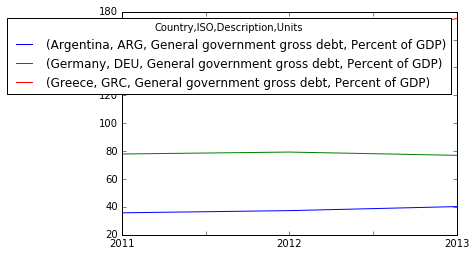

In [46]:
# we can even do a plot
debt.plot()

**Example.** Let's do this together.  How would we fix up the legend?  What approaches cross your mind?  (No code, just the general approach.) 

<a id='stack'></a>

## Stacking and unstacking 

The `set_index` and `reset_index` methods work on the row labels -- the index.  The `stack` and `unstack` methods work on the column labels.  

* `stack` stacks the data up, moving the columns to the index and creating a "long" dataframe.
* `unstack` does the reverse, moving columns or index levels into the column labels and creating a "wide" dataframe.  

This sounds a little abstract, but it's incredibly useful. 

Two wants:

* Org by variable and plot
* Org by country and plot 

In [47]:
# drop some of the index levels (think s for small)
dds = ddi.reset_index(level=[1,3,4], drop=True)
dds.columns.name = 'Year'
dds

,Year,2011,2012,2013
Variable,ISO,,,
Surplus,ARG,-1.949,-2.359,-1.997
Debt,ARG,35.763,37.328,40.217
Surplus,DEU,-0.861,0.091,0.133
Debt,DEU,77.928,79.311,76.978
Surplus,GRC,-10.215,-6.406,-2.944
Debt,GRC,170.960,156.494,174.951


In [48]:
# convert to long format 
ds = dds.stack()    # level=bottom is default 
ds

Variable  ISO  Year
Surplus   ARG  2011     -1.949
               2012     -2.359
               2013     -1.997
Debt      ARG  2011     35.763
               2012     37.328
               2013     40.217
Surplus   DEU  2011     -0.861
               2012      0.091
               2013      0.133
Debt      DEU  2011     77.928
               2012     79.311
               2013     76.978
Surplus   GRC  2011    -10.215
               2012     -6.406
               2013     -2.944
Debt      GRC  2011    170.960
               2012    156.494
               2013    174.951
dtype: float64

In [49]:
# same thing
dds.stack(level='Year')

Variable  ISO  Year
Surplus   ARG  2011     -1.949
               2012     -2.359
               2013     -1.997
Debt      ARG  2011     35.763
               2012     37.328
               2013     40.217
Surplus   DEU  2011     -0.861
               2012      0.091
               2013      0.133
Debt      DEU  2011     77.928
               2012     79.311
               2013     76.978
Surplus   GRC  2011    -10.215
               2012     -6.406
               2013     -2.944
Debt      GRC  2011    170.960
               2012    156.494
               2013    174.951
dtype: float64

In [51]:
# now go long to wide 
dds.unstack()  # defalult is lowest value level='ISO'

Year        2011                     2012                     2013          \
ISO          ARG     DEU      GRC     ARG     DEU      GRC     ARG     DEU   
Variable                                                                     
Debt      35.763  77.928  170.960  37.328  79.311  156.494  40.217  76.978   
Surplus   -1.949  -0.861  -10.215  -2.359   0.091   -6.406  -1.997   0.133   

Year               
ISO           GRC  
Variable           
Debt      174.951  
Surplus    -2.944

In [52]:
# different level 
dds.unstack(level='Variable')

Year         2011             2012             2013        
Variable     Debt Surplus     Debt Surplus     Debt Surplus
ISO                                                        
ARG        35.763  -1.949   37.328  -2.359   40.217  -1.997
DEU        77.928  -0.861   79.311   0.091   76.978   0.133
GRC       170.960 -10.215  156.494  -6.406  174.951  -2.944

**Exercise.** Run the code below and explain what each line of code does.  

*Bonus:* How would you unstack `ISO` first, then `Variable`?  Can you do it in one line?

In [42]:
du1 = ds.unstack() 
du2 = du1.unstack()

## Pivoting

Think about where we want to end up.  What is the index?  The columns?  The values? 

In [53]:
dds

,Year,2011,2012,2013
Variable,ISO,,,
Surplus,ARG,-1.949,-2.359,-1.997
Debt,ARG,35.763,37.328,40.217
Surplus,DEU,-0.861,0.091,0.133
Debt,DEU,77.928,79.311,76.978
Surplus,GRC,-10.215,-6.406,-2.944
Debt,GRC,170.960,156.494,174.951


In [44]:
dds.pivot(index='Year', columns='Variable') 

KeyError: 'Years'

**Comment.** Now use stack and unstack to org data by, first, country and, second, variable.  

In [ ]:
ds = dds.stack()
ds

In [ ]:
dv = ds.unstack(level=['Variable', 'ISO'])
dv

In [ ]:
dv['Surplus']

In [ ]:
dv['Surplus'].plot()

In [ ]:
# no go the other way
dc = ds.unstack(level=['ISO', 'Variable'])
dc

In [ ]:
dc['ARG']

In [ ]:
dc['ARG'].plot(subplots=True) 

**Exercise.** BDS data...  ??

### Example:  OECD healthcare statistics 

The OECD collects [healthcare data](http://www.oecd.org/els/health-systems/health-data.htm) on lots of (mostly rich) countries, which is helpful in producing comparisons.  Here we use a [spreadsheet](http://www.oecd.org/health/health-systems/OECD-Health-Statistics-2015-Frequently-Requested-Data.xls) linked in one of their documents. 

In [24]:
url1 = 'http://www.oecd.org/health/health-systems/'
url2 = 'OECD-Health-Statistics-2015-Frequently-Requested-Data.xls'
docs = pd.read_excel(url1+url2, 
                     skiprows=3, 
                     usecols=[0, 51, 52, 53, 54, 55, 57],
                     sheetname='Physicians', 
                     na_values=['..'],   # added 
                     skip_footer=21) 
print('Dimensions:', docs.shape)
print('\nVariable dtypes:\n', docs.dtypes.tail(8), sep='')

# change name of country variable 
names = docs.columns
docs = docs.rename(columns={names[0]: 'Country'})

# fix country variable 
# now assign it back to the variable 
docs['Country'] = docs['Country'].str.rsplit(n=1).str[0]

docs.head()

Dimensions: (34, 7)

Variable dtypes:
Unnamed: 0                 object
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2013 (or nearest year)    float64
dtype: object


,Country,2010,2011,2012,2013,2014,2013 (or nearest year)
0,Australia,NaN,3.31,3.31,3.39,NaN,3.39
1,Austria,4.80,4.84,4.90,4.99,NaN,4.99
2,Belgium,2.92,2.91,2.93,2.95,NaN,2.95
3,Canada,2.37,2.44,2.50,2.55,NaN,2.55
4,Chile,1.43,1.58,1.74,1.88,2.02,1.88
